In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

import pmdarima.arima as pmd
from pmdarima import model_selection
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Copy the dataset.zip and unzip it
!cp "/content/drive/MyDrive/Microchip/dataset.zip" "/content"
!unzip dataset.zip

Archive:  dataset.zip
  inflating: dataset/pcb_1.jpg       
  inflating: dataset/pcb_2.jpg       
  inflating: dataset/pcb_3.jpg       
  inflating: dataset/pcb_4.jpg       
  inflating: dataset/pcb_5.jpg       
  inflating: dataset/pcb_6.jpg       
   creating: dataset/typeA/
   creating: dataset/typeA/test/
  inflating: dataset/typeA/test/annotations.csv  
   creating: dataset/typeA/train/
  inflating: dataset/typeA/train/annotations.csv  
   creating: dataset/typeB/
   creating: dataset/typeB/test/
  inflating: dataset/typeB/test/annotations.csv  
   creating: dataset/typeB/train/
  inflating: dataset/typeB/train/annotations.csv  
   creating: dataset/typeC/
   creating: dataset/typeC/test/
  inflating: dataset/typeC/test/annotations.csv  
   creating: dataset/typeC/train/
  inflating: dataset/typeC/train/annotations.csv  
   creating: dataset/typeD/
   creating: dataset/typeD/test/
  inflating: dataset/typeD/test/annotations.csv  
   creating: dataset/typeD/train/
  inflating: data

In [5]:
def load_dataset(filename):
    # Read the .csv
    df = pd.read_csv(filename, delimiter=';')
    # Drop columns that we don't need
    df_cleaned = df.drop(df.columns[[0, 1, 2, 3]],axis = 1)
    # Set Dataframe's dtype to float32
    df_cleaned = df_cleaned.astype(np.float32)

    return df_cleaned

In [6]:
types = ['typeA', 'typeB', 'typeC', 'typeD', 'typeE']

In [7]:
orders = {'typeA': {'50um': (0,1,0),
                    '20um': (0,1,0)},
          'typeB': {'50um': (0,1,0),
                    '20um': (0,1,0)},
          'typeC': {'50um': (0,1,0),
                    '20um': (0,1,0)},
          'typeD': {'50um': (0,1,0),
                    '20um': (0,1,0)},
          'typeE': {'50um': (0,1,0),
                    '20um': (0,1,0)}}


Performing time series analysis for typeA



100%|██████████| 99/99 [00:00<00:00, 273.79it/s]


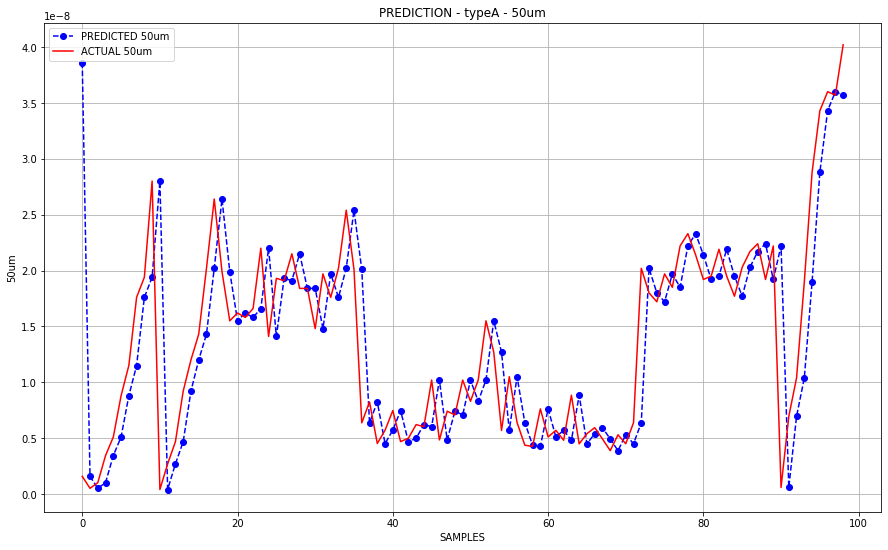


Mean Squared Error: 4.232081220856837e-17



100%|██████████| 99/99 [00:00<00:00, 272.75it/s]


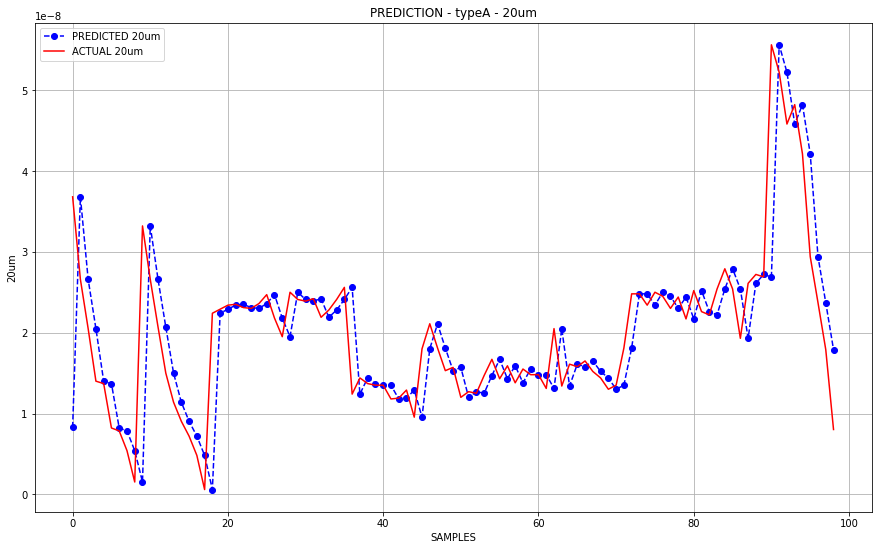


Mean Squared Error: 4.6918855577325243e-17


Performing time series analysis for typeB



100%|██████████| 99/99 [00:00<00:00, 282.93it/s]


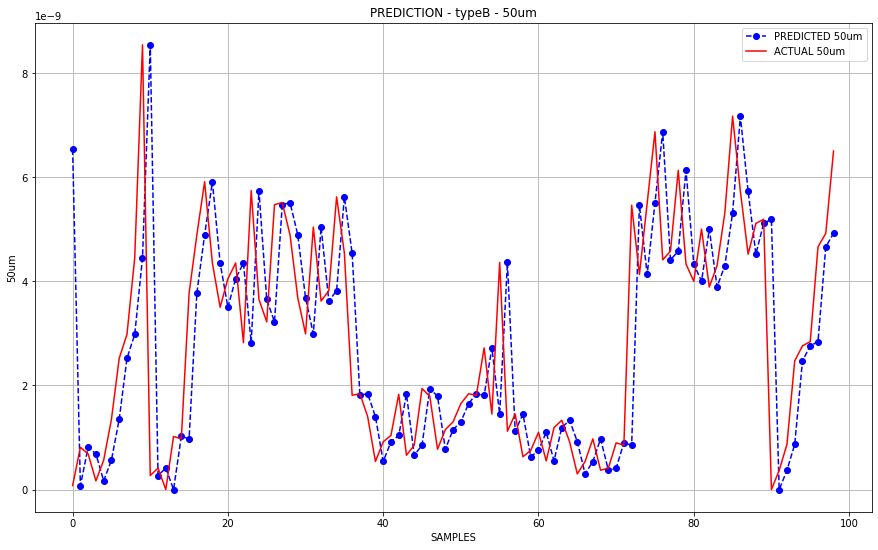


Mean Squared Error: 3.063741246410975e-18



100%|██████████| 99/99 [00:00<00:00, 204.52it/s]


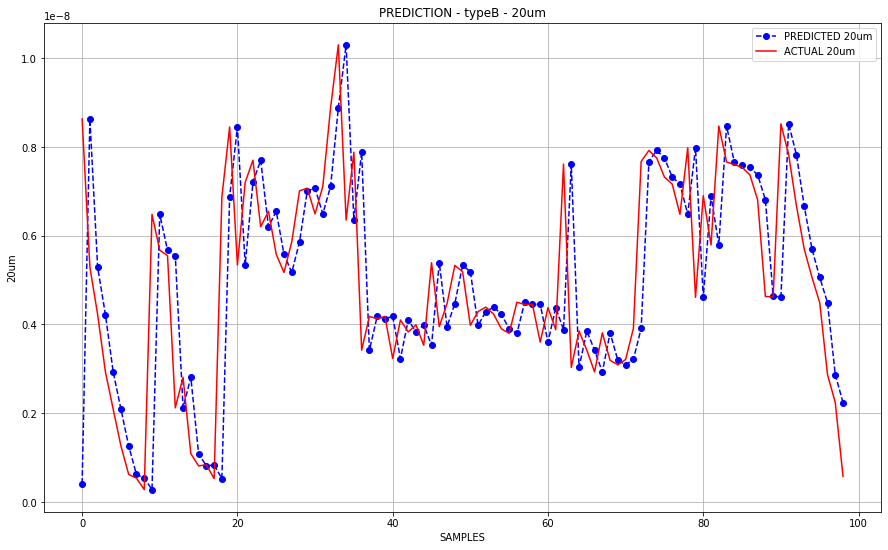


Mean Squared Error: 3.69633531459761e-18


Performing time series analysis for typeC



100%|██████████| 99/99 [00:00<00:00, 276.97it/s]


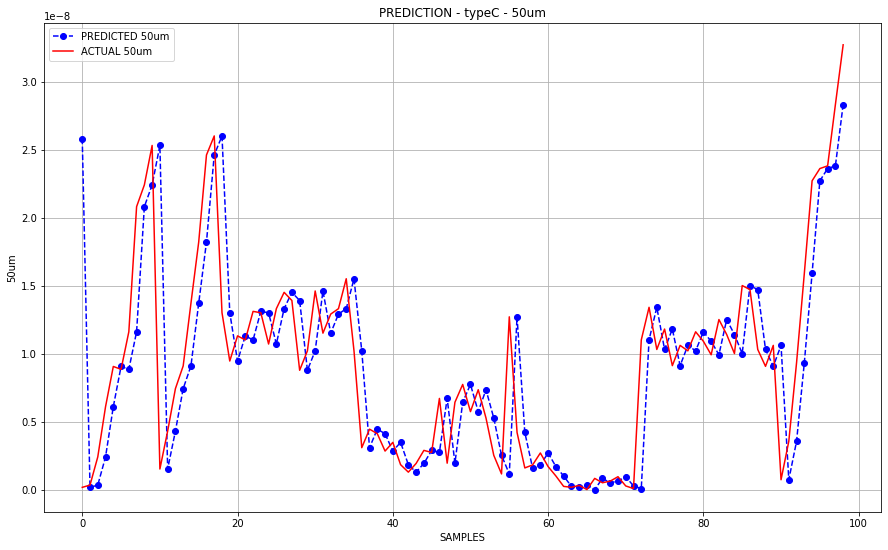


Mean Squared Error: 2.6133928911850164e-17



100%|██████████| 99/99 [00:00<00:00, 258.86it/s]


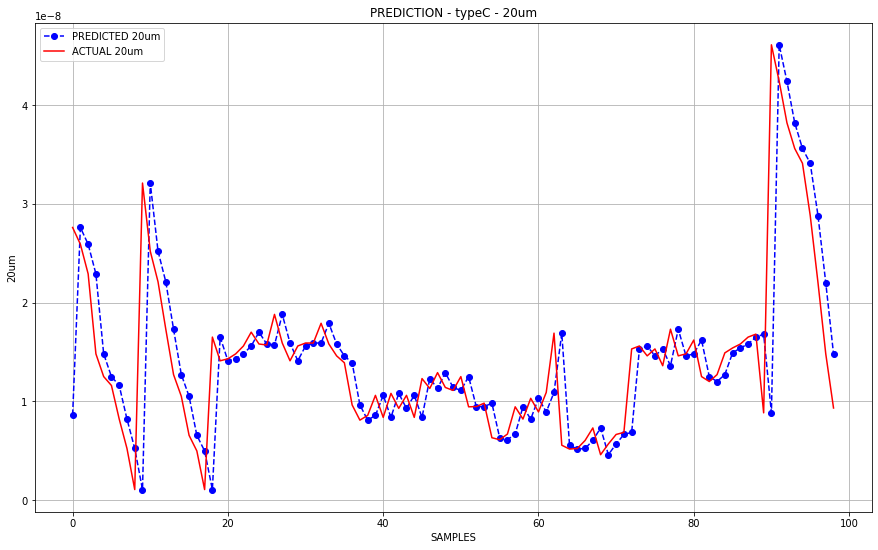


Mean Squared Error: 3.961389838290749e-17


Performing time series analysis for typeD



100%|██████████| 99/99 [00:00<00:00, 262.16it/s]


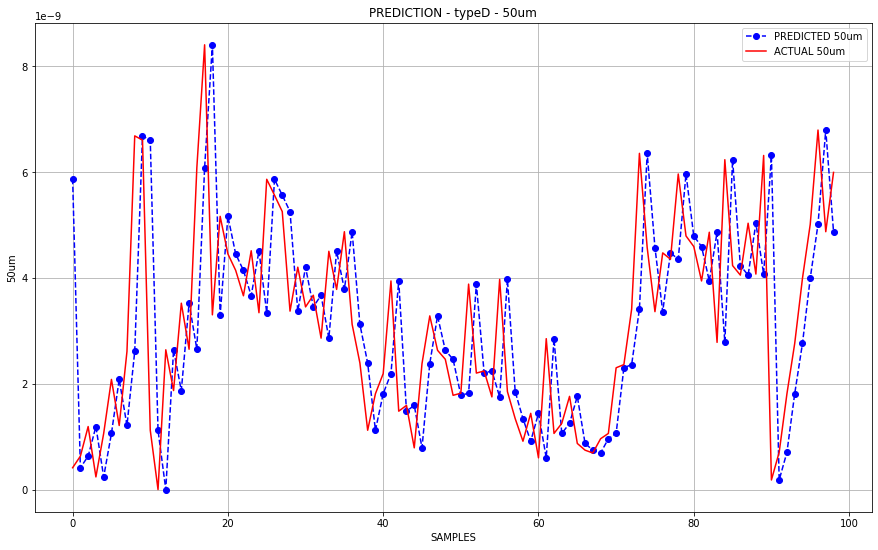


Mean Squared Error: 3.1115456434984734e-18



100%|██████████| 99/99 [00:00<00:00, 256.09it/s]


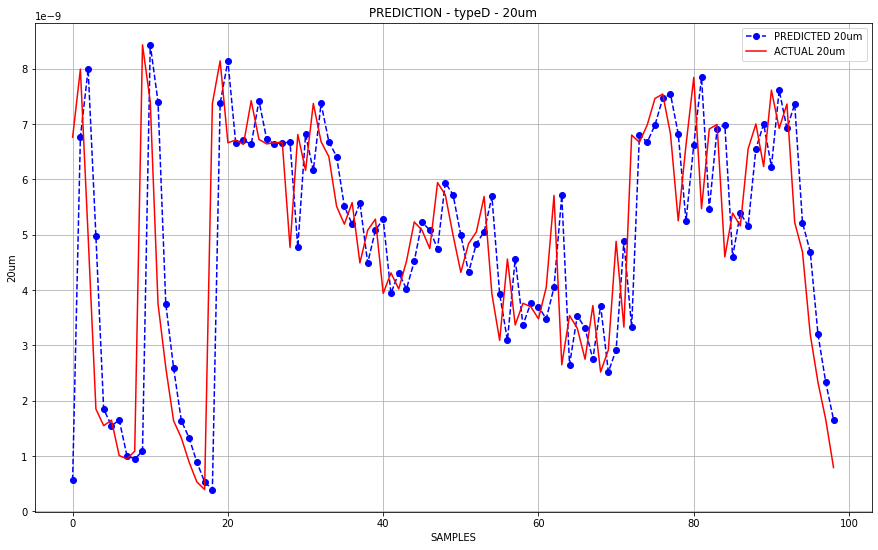


Mean Squared Error: 2.8164028790920582e-18


Performing time series analysis for typeE



100%|██████████| 99/99 [00:00<00:00, 271.86it/s]


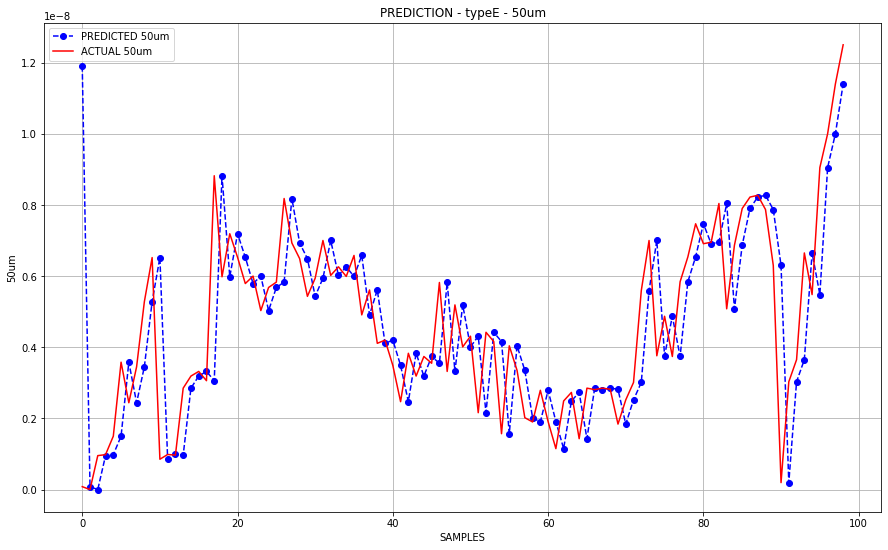


Mean Squared Error: 4.267383686634924e-18



100%|██████████| 99/99 [00:00<00:00, 259.62it/s]


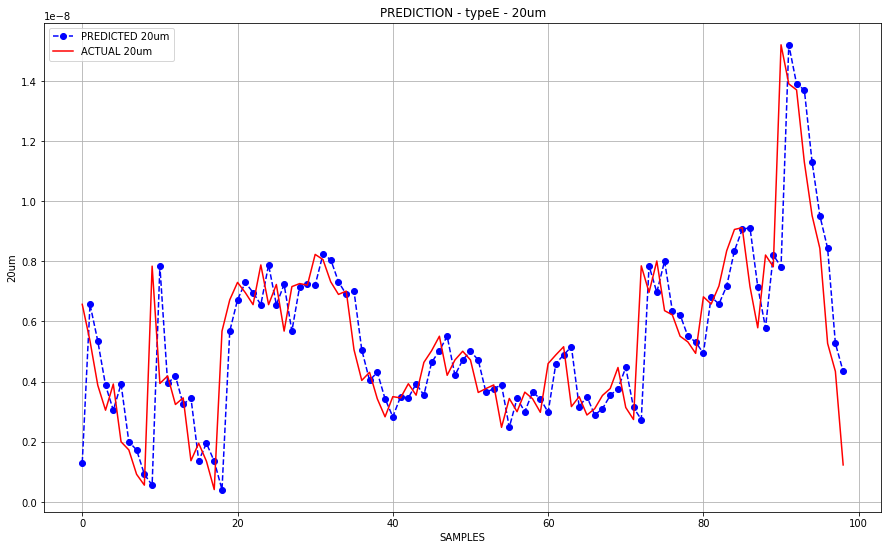


Mean Squared Error: 3.167209410392587e-18



In [9]:
with open(f"tsa_logs.txt",'w',encoding = 'utf-8') as f:
    for type in types:
        # Define train csv filename
        train_filename = f"/content/dataset/{type}/train/annotations.csv"
        test_filename = f"/content/dataset/{type}/test/annotations.csv"

        print(f"\nPerforming time series analysis for {type}\n")

        train_df = load_dataset(train_filename)
        test_df = load_dataset(test_filename)

        feature_types = ['50um', '20um']
        for feature in feature_types:
            
            # data = train_df[feature]
            # plt.plot(train_df.index, data)
            # plt.show()

            # Train test split
            # to_row = int(len(df_cleaned)*0.9)
            training_data = list(train_df[feature])
            testing_data = list(test_df[feature])

            test_df.index += len(train_df)

            # plt.figure(figsize=(10, 6))
            # plt.grid(True)
            # plt.xlabel('SAMPLES')
            # plt.ylabel(feature)
            # plt.plot(train_df[feature], 'green', label='Train Data')
            # plt.plot(test_df[feature], 'blue', label='Test Data')
            # plt.legend()
            # plt.show()

            to_test_data = []
            predictions = []
            seq_len = 1
            len_testing = len(testing_data)

            total_df_length = len(train_df) + len(test_df)
            total_df = pd.concat([train_df, test_df])

            for i in range(len(training_data)-seq_len, total_df_length-seq_len):
                to_test_data.append(list(total_df[feature].iloc[i:i+seq_len]))

            for i in tqdm(range(len_testing), total=len(range(len_testing))):
                model = ARIMA(to_test_data[i], order=orders[type][feature], enforce_stationarity=False)
                model_fit = model.fit()
                output = model_fit.forecast()
                y_hat = list(output)[0]
                predictions.append(y_hat)

            test_df.index -= len(train_df)
            sample_range = test_df.index

            plt.figure(figsize=(15,9))
            plt.grid(True)
            plt.plot(sample_range, predictions, color='blue', marker='o', linestyle='dashed', label=f'PREDICTED {feature}')
            plt.plot(sample_range, testing_data, color='red', label=f'ACTUAL {feature}')
            plt.title(f'PREDICTION - {type} - {feature}')
            plt.xlabel('SAMPLES')
            plt.ylabel(f'{feature}')
            plt.legend()
            plt.savefig(f"tsa_{feature}_{type}_predictions.jpg")
            plt.show()

            # report performance
            MSE = mean_squared_error(testing_data, predictions)
            print(f"\nMean Squared Error: {MSE}\n")
            f.write(f"MSE for {feature} -- {type}: {MSE}\n")

            
        